<a href="https://colab.research.google.com/github/marktfaust/LSTM-Image-Generator/blob/main/Mark_Faust_DL_Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #4: An LSTM-Based Generative Model of Images  (15 Total Points)

In this homework, we will work with the LSTM architecture but in a slightly different application than the predominantly text-based ones we discussed in class: image generation.  We can think of an image $\mathbf{X} \in \mathbb{R}^{D \times D}$ as a time series by re-interpreting one or more of the spatial dimensions as time.  While this might seem strange at first, think of drawing by hand: your pen strokes are naturally ordered by time.  This intuition underlies [*Pixel Recurrent Neural Networks (PixelRNNs)*](https://arxiv.org/abs/1601.06759), which was the state-of-the-art model for image generation around 2016.  In this assignment, we will work with a drastically simplified version of this model, where we take the rows of an image and treat them as a time series, predicting the $t$-th row with a LSTM that has already observed rows $1,\ldots, t-1$.

Let's start by importing the usual libraries....

In [1]:
# Numpy and MatPlotLib
import matplotlib.pyplot as plt
import numpy as np

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# PyTorch Utils for Data Processing
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

## Loading the MNIST dataset

For the images on which we'll train the model, we'll use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database): 28x28 black-and-white images of handwritten digits.  There are 10 classes corresponding to the digits 0 to 9.  Training on all of them is too costly to do in this homework assignment so we will just get the images that correspond to handwritten 1's.

In [2]:
# choose just one class of the MNIST digits to train on
# 1's are best for this assignment
label_to_get = 1

# Dataset: grab only datapoints with the index of 'label_to_get'
full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
indices_of_target_label = [i for i, (img, label) in enumerate(full_train) if label == label_to_get]
ones_subset = Subset(full_train, indices_of_target_label)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.80MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.00MB/s]


To verify that we collected the correct subset and to get a sense of what the images look like, let's visualize the first 10 images.

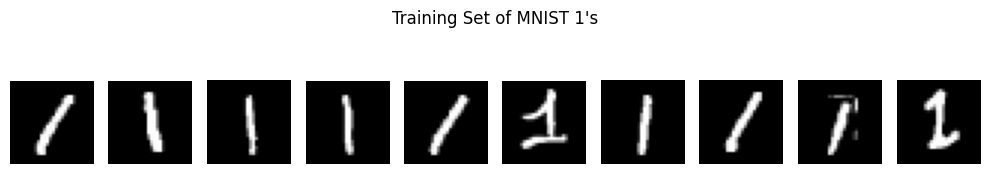

In [3]:
# Plot the first 10 images
plt.figure(figsize=(10, 2))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(full_train.data[indices_of_target_label[i], :, :], cmap="gray")
    plt.axis('off')

plt.suptitle("Training Set of MNIST 1's")
plt.tight_layout()
plt.show()

## Defining the Model  (9 Points)

We will now define an LSTM model that parameterizes an autoregressive model on the *rows* of the above images.  Again, the images above are of size $28 x 28$, and let $\mathbf{X}_n$ represent the $n$-th image of the training set.  We can decompose $\mathbf{X}_n$ into rows as $\mathbf{X}_n = [\mathbf{x}_{n,1}, \ldots, \mathbf{x}_{n,28}]$, where $\mathbf{x}_{n,t} \in \{0, 1\}^{28}$, meaning that $\mathbf{x}_{n,t}$ is a 28-dimensional binary vector.  Since there are 28 rows in $\mathbf{X}_n$, that means we have a time series of 28 elements (i.e. $T=28$), each being a 28-dimensional binary vector.  

We can then write the auto-regressive likelihood for one image as:
$$ p(\mathbf{X}_n) \ = \ \prod_{t=1}^{28} p(\mathbf{x}_{n,t} | \mathbf{x}_{n,t-1}, \ldots, \mathbf{x}_{n,1}).$$  Since the elements of the series are binary vectors, we can parameterize them with the Bernoulli distribution.  We'll have a Bernoulli distribution for each output dimension, but their parameters will all be a function of the LSTM:
$$ p(\mathbf{X}_n) \ = \  \prod_{t=1}^{28} \prod_{d=1}^{28} \text{Bernoulli}\left(x_{n,t,d} ; \ \pi_{n,t,d} = \text{logistic}(\mathbf{w}^{T}_{d} \ \mathbf{h}_{n,t})\right)$$ $$\text{ where } \mathbf{h}_{n,t} = \text{LSTM}\left(\mathbf{h}_{t-1}, \mathbf{x}_{n,t-1} \right). $$  This means that each row $\mathbf{x}_{n,t}$ is input into the LSTM.  The LSTM's hidden state $\mathbf{h}_{n,t} \in (0, 1)^{H}$, where $H$ is a user-specified dimensionality.  The hidden state is then multiplied by $\mathbf{w}_{d} \in \mathbb{R}^{H}$ and the output transformed by a logistic inverse link function to produce $\pi_{t,d}$, the Bernoulli parameter for the pixel in the $t$-th row and $d$-th column.
Finally, we can write the training objective as the negative log probability of all $N$ training images:
$$ \ell(\theta; \mathbf{X}_{1}, \ldots, \mathbf{X}_{N}) \ = \ - \log \left\{ \prod_{n=1}^{N} \prod_{t=1}^{28} \prod_{d=1}^{28} \text{Bernoulli}\left(x_{n,t,d} ; \ \pi_{n,t,d} = \text{logistic}(\mathbf{w}^{T}_{d} \ \mathbf{h}_{n,t})\right)  \right\} $$ $$ = \sum_{n=1}^{N} \sum_{t=1}^{28} \sum_{d=1}^{28} - x_{n,t,d} \cdot \log \left\{\text{logistic}(\mathbf{w}^{T}_{d} \ \mathbf{h}_{n,t}) \right\} - (1-x_{n,t,d}) \cdot \log \left\{ 1 - \text{logistic}(\mathbf{w}^{T}_{d} \ \mathbf{h}_{n,t}) \right\}.$$

**Problem #1** **(7 points)**: Define the model above as a PyTorch class.  [See the documentation on PyTorch's LSTM implementation.](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

In [4]:
class BernoulliLSTM(nn.Module):
    def __init__(self, input_dim=28, hidden_dim=128, batch_first=True):
        ### INPUT ARGUMENTS ###
        # input_dim: dimension of input at each time step
        # hidden_dim: dimension of hidden state
        # batch_first: If 'True', then the the input and output tensors are provided as (batch, seq, feature).
        ### YOUR SOLUTION GOES HERE ###
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_first = batch_first

        # TODO: Correct to have 1 layer?
        self.lstm = nn.LSTM(
            self.input_dim,
            self.hidden_dim,
            num_layers=1,
            batch_first=self.batch_first
        )

        # TODO: Put into forward and extract D then set, or continue to assume output_dim = self.input_dim?
        self.output_layer = nn.Linear(self.hidden_dim, self.input_dim)
        self.logistic = nn.Sigmoid()

    def forward(self, x):
        ### INPUT ARGUMENTS ###
        # x: input to the LSTM, which is of size [B, T, D] where B is the batch size, T is the max number of time steps (T=28), and D is the dimensionality of each input vector (D=28)
        ### OUTPUTS ###
        # Return an output of size [B, T, D] (same values as above), which consists of the Bernoulli parameters π_{t,d}.  Use torch.nn.Sigmoid to implement the logistic function.
        ### YOUR SOLUTION GOES HERE ###
        output, _ = self.lstm(x)
        logits = self.output_layer(output)
        bernoulli_params = self.logistic(logits)
        return bernoulli_params


**Problem #2** (2 points): [choose the appropriate PyTorch function](https://pytorch.org/docs/stable/nn.html#loss-functions) to implement the loss function defined above as $\ell(\theta; \mathbf{X}_{1}, \ldots, \mathbf{X}_{N})$, where $\theta$ denotes all the RNN's parameters.

In [5]:
# choose the appropriate loss function from https://pytorch.org/docs/stable/nn.html#loss-functions
training_loss = nn.BCELoss()

## Training the LSTM Model  (5 Points)

Now we are ready to train the model.  Let's first define a batch size and a [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which will provide an easy mechanism for iterating over the training batches.

In [6]:
batch_size = 128
train_loader = DataLoader(ones_subset, batch_size=batch_size, shuffle=True)

Now let's implement the training logic.

**Problem #3** **(5 points)**: Implement the optimization step.  We've used this pattern before in discussion exercises, but see if the [PyTorch optim documentation](https://pytorch.org/docs/stable/optim.html) if you need a refersher.  Leave the epoch and step_size parameters to their default values (until your implementation works and you want to explore how different settings impact the results).

In [7]:
def binarize_batch(batch):
  # Given a value between [0,1], this function
  # returns a sample from a Bernoulli distribution
  # with that input parameter
  return torch.bernoulli(batch)


### TRAINING HYPERPARAMS ###
epochs = 5
step_size = 0.001


### DEFINE MODEL AND OPTIMIZER ###
model = BernoulliLSTM()
optimizer = optim.Adam(model.parameters(), lr=step_size)


### TRAINING LOOP ###
for epoch in range(epochs):

    model.train()

    total_loss = 0
    for batch, _ in train_loader:
        # sample Bernoullis to make the image pixels in {0, 1}
        batch = binarize_batch(batch.squeeze(1))  # [B, 28, 28]
        # split the batch into inputs and training targets
        input_seq = batch[:, :-1, :]   # [B, 27, 28]
        target_seq = batch[:, 1:, :]   # [B, 27, 28]

        ### IMPLEMENT THE OPTMIZATION STEP ###
        ### YOUR SOLUTION GOES HERE ###
        optimizer.zero_grad()
        output_seq = model(input_seq)
        loss =  training_loss(output_seq, target_seq)
        loss.backward()
        optimizer.step()
        #######################################

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.3766
Epoch 2, Loss: 0.2125
Epoch 3, Loss: 0.1809
Epoch 4, Loss: 0.1535
Epoch 5, Loss: 0.1337


## Generating Images  (1 Point)

After training, we can now sample new images from the model.  One way is to sample from the Bernoulli distributions we used to define the model:
$$ \hat{x}_{t,d} \sim \text{Bernoulli}(x_{t,d}; \pi_{t,d} = \text{logistic}(\mathbf{w}_{d}^{T} \mathbf{h}_{t})). $$
That version is implemented for you below.  When your implementation is working, your samples should look similar to those below.  While not a perfect '1', we should clearly see the sampled white pixels forming a fuzzy vertical line:
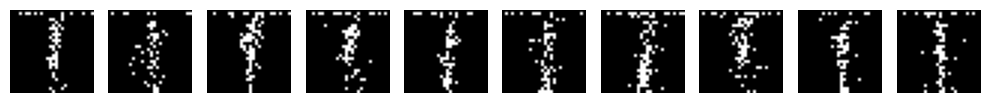  



However, we could also perform `greedy' decoding from the model.  This will return the modal pixel-wise configuration and be a deterministic output.  You'll have to implement that version.

**Problem #4 (1 point):** Implement 'greedy' decoding, where instead of being sampled, the probabilities are thresholded at the variable 'greedy_threshold'.  This means that if the Bernoulli parameter is above 'greedy_threshold', return the value 1 and 0 otherwise.

In [8]:
# Generation: sample rows autoregressively from Bernoulli distribution
def generate_images(n=10, decoding_type="sample", greedy_threshold=0.2):
    model.eval()
    generated_images = []
    with torch.no_grad():
        for _ in range(n):
            # initalize the input to all zeros
            rows = [torch.zeros(1, 1, 28)]  # start with all-zero row
            hidden = None
            for _ in range(27):
                input_seq = torch.cat(rows, dim=1)  # [1, T, 28]
                # propagate the LSTM
                out, hidden = model.lstm(input_seq, hidden)
                # get the logits
                logits = model.output_layer(out[:, -1:, :])
                # get the Bernoulli params / success probabilities
                probs = torch.sigmoid(logits)

                # decoding by sampling from the Bernoulli
                if decoding_type == "sample":
                    sampled_row = torch.bernoulli(probs)

                # decoding by deterministic, greedy threshold
                elif decoding_type == "greedy":
                    ### YOUR SOLUTION GOES HERE ###
                    sampled_row = (probs > greedy_threshold).int()

                # add sampled row to image
                rows.append(sampled_row)

            # collect images
            image = torch.cat(rows, dim=1).squeeze().numpy()
            generated_images.append(image)

    # Plot images
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i], cmap="gray")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

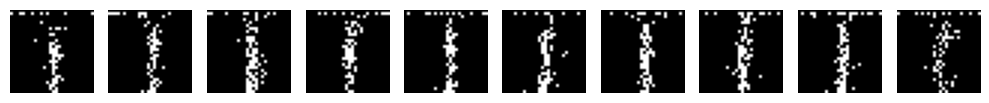

In [9]:
generate_images(decoding_type="sample")

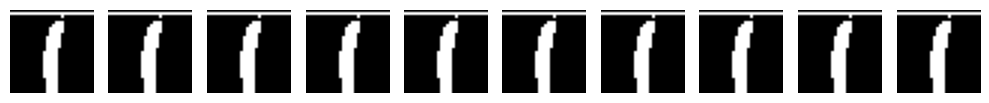

In [10]:
generate_images(decoding_type="greedy")

## Uploading your Solution

Turn in your solution via Gradescope (accessed through Canvas).  You need to upload *two* files to two different assignment pages within Gradescope:
*   a PDF of your code and solutions as shown in the notebook.  You can generate it via File > Print > Save as PDF.  Make sure all of your code and plotting cells are visible.
*   a Python file (file.py).  You can export one from the notebook via File > Download > Download .py.